# Mercado Libre Data Challenge

### Importar módulos necesarios

In [3]:
import requests
import json
import pandas as pd
import numpy as np
from pandas import json_normalize
import time

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns

## Obtener token de acceso

In [5]:
client_id = "8782676683401387"
client_secret = "ZVZtn7SyembB8liDi1aU3JYd6ONgg2sX"
redirect_uri = "https://localhost:3000"

# Replace with the appropriate Mercado Libre site ID for your region
site_id = "MLM"

# URL for Mercado Libre's OAuth 2.0 authorization endpoint
auth_url = f"https://auth.mercadolibre.com.mx/authorization?response_type=code&client_id={client_id}&redirect_uri={redirect_uri}&site_id={site_id}"

In [6]:
# Redirect the user to the authorization URL
print(f"Visit the following URL to authorize the application:\n{auth_url}")

# After user authorization, obtain the authorization code from the redirected URL
authorization_code = input("Enter the authorization code from the redirected URL: ")

# URL for Mercado Libre's OAuth 2.0 token endpoint
token_url = "https://api.mercadolibre.com/oauth/token"

# Request access token using the authorization code
token_data = {
    "grant_type": "authorization_code",
    "client_id": client_id,
    "client_secret": client_secret,
    "redirect_uri": redirect_uri,
    "code": authorization_code
}

token_response = requests.post(token_url, data=token_data)
access_token = token_response.json().get("access_token")


print(f"Access Token: {access_token}")

Visit the following URL to authorize the application:
https://auth.mercadolibre.com.mx/authorization?response_type=code&client_id=8782676683401387&redirect_uri=https://localhost:3000&site_id=MLM


Enter the authorization code from the redirected URL:  TG-65a35d833f9ce9000190ec95-1583124477


Access Token: APP_USR-8782676683401387-011400-dce6ad5287433e0438122d8950a6ca13-1583124477


## Elegir categoría de interés 

In [ ]:
# Elegí la categoría "Electrónica, Audio y Video" en MX
category_id = site_id+"1000"

## Obtener lista de sellers en la categoría

- Me interesa obtener la mayor cantidad posible de datos, pero no sé cuántos hay disponibles. 
- Voy a iterar sobre 'offset' hasta que la API arroje un error para saber con cuántos datos cuento.

In [11]:
%%time
limit = 50  
offset = 0
all_items = []

while True:
    url = f"https://api.mercadolibre.com/sites/{site_id}/search?category={category_id}&access_token={access_token}&offset={offset}&limit={limit}"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        items = data.get("results", [])
        #seller_id = items.get("seller", []).get("id","Unknown")

        if not items:
            break
        
        # Adjuntar a lista de todos los items
        all_items.extend(items)

        # Aumentar el offset
        offset += limit-1
    else:
        print(f"Error: {response.status_code} - {response.text}")
        break

print(f"Total items in category: {len(all_items)}")


Error: 403 - {"message":"the requested offset is higher than the allowed for public users. Maximum allowed is 4000","error":"forbidden","status":403,"cause":[]}
Total items in category: 4042
CPU times: user 3.41 s, sys: 58.6 ms, total: 3.47 s
Wall time: 18.1 s


- Tengo acceso solamente a los primeros 4050 items en la categoría. 
- Voy a analizar a los sellers de esos 4050 items, que probablemente serán menos de 4050.

## Obtener datos de reputación del comprador

In [14]:
%%time

sellers_data = []

for item in all_items:
        seller = item.get("seller", {})
        seller_id = item.get("seller", {}).get("id", "")
        if seller_id:
            seller_details_url = f"https://api.mercadolibre.com/users/{seller_id}/?access_token={access_token}"
            seller_details_response = requests.get(seller_details_url)

            if seller_details_response.status_code == 200:
                seller_details = seller_details_response.json()
                
                seller_level = seller_details.get("seller_reputation", {}).get("level_id", "Unknown")
                seller_status = seller_details.get("seller_reputation", {}).get("power_seller_status", "Unknown")
                seller_transactions_period = seller_details.get("seller_reputation", {}).get("transactions", {}).get("period", "Unknown")
                seller_transactions_total = seller_details.get("seller_reputation", {}).get("transactions", {}).get("total", "Unknown")
                seller_metrics = seller_details.get("seller_reputation", {}).get("metrics", "Unknown")
                seller_transactions = seller_details.get("seller_reputation", {}).get("transactions", "Unknown")
                
                sellers_data.append({
                    "seller": seller,
                    "seller_id": seller_id,
                    "level": seller_level,
                    "status": seller_status,
                    "transactions_period": seller_transactions_period,
                    "transactions_total": seller_transactions_total,
                    "metrics": seller_metrics,
                    "transactions_general": seller_transactions
            })
                
              ##  print(f"""Seller ID: {seller_id}, 
              ##      Level_id: {seller_level}, 
              ##      Status: {seller_status}, 
              ##      Transactions: {seller_transactions_total}, 
              ##      Transactions period: {seller_transactions_period},
              ##      Metrics: {seller_metrics},
              ##      Transactions_general: {seller_transactions}""")
            else:
                print(f"Error fetching details for Seller ID {seller_id}. Status Code: {seller_details_response.status_code}")


CPU times: user 2min 28s, sys: 1.49 s, total: 2min 30s
Wall time: 4min 13s


## Obtener datos de reviews de productos

In [95]:
%%time

reviews_data = []
redo_items=[]

for item in all_items:
        item_id = item.get("id", {})
        #item_cat_id = item.get("catalog_product_id", {})
        if item_id:
            item_reviews_url = f"https://api.mercadolibre.com/reviews/item/{item_id}/?access_token={access_token}"
            item_reviews_response = requests.get(item_reviews_url)

            if item_reviews_response.status_code == 200:
                item_details = item_reviews_response.json()
                
                rating_average = item_details.get("rating_average", "Unknown")
               
                reviews_data.append({
                    "id": item_id,
                    "rating_average": rating_average,
                })
                time.sleep(0.15)
            else:
                if item_reviews_response.status_code == 429:
                    if "Retry-After" in response.headers:
                        retry_after_seconds = int(response.headers["Retry-After"])
                        print(f"Received 429. Waiting for {retry_after_seconds} seconds.")
                        time.sleep(retry_after_seconds)
                        response = requests.get(item_reviews_url)
                    else:
                        print(f"Error en item {item_id}.429.Recibidos:{len(reviews_data)} de {len(all_items)}")
                        redo_items.append(item_id)
                        time.sleep(20)
    
    
                else:
                    print(f"Error fetching details for item ID {item_id}. Status Code: {item_reviews_response.status_code}")


Error en item MLM2077525264.429.Recibidos:153 de 4042
Error en item MLM1919586747.429.Recibidos:225 de 4042
Error en item MLM1936512639.429.Recibidos:294 de 4042
Error en item MLM2645896126.429.Recibidos:345 de 4042
Error en item MLM2000230721.429.Recibidos:407 de 4042
Error en item MLM1917475687.429.Recibidos:453 de 4042
Error en item MLM2566590090.429.Recibidos:509 de 4042
Error en item MLM2683456296.429.Recibidos:553 de 4042
Error en item MLM2804696038.429.Recibidos:616 de 4042
Error en item MLM1984985013.429.Recibidos:672 de 4042
Error en item MLM1500998395.429.Recibidos:727 de 4042
Error en item MLM1983950697.429.Recibidos:793 de 4042
Error en item MLM2341108762.429.Recibidos:835 de 4042
Error en item MLM2096640792.429.Recibidos:889 de 4042
Error en item MLM1992899369.429.Recibidos:981 de 4042
Error en item MLM1967918795.429.Recibidos:1030 de 4042
Error en item MLM1937023167.429.Recibidos:1085 de 4042
Error en item MLM2571446520.429.Recibidos:1142 de 4042
Error en item MLM19866763

In [96]:
%%time

for item in redo_items:
        item_id = item
        #item_cat_id = item.get("catalog_product_id", {})
        if item_id:
            item_reviews_url = f"https://api.mercadolibre.com/reviews/item/{item_id}/?access_token={access_token}"
            item_reviews_response = requests.get(item_reviews_url)

            if item_reviews_response.status_code == 200:
                item_details = item_reviews_response.json()
                
                rating_average = item_details.get("rating_average", "Unknown")
               
                reviews_data.append({
                    "id": item_id,
                    "rating_average": rating_average,
                })
                time.sleep(0.15)
            else:
                if item_reviews_response.status_code == 429:
                    if "Retry-After" in response.headers:
                        retry_after_seconds = int(response.headers["Retry-After"])
                        print(f"Received 429. Waiting for {retry_after_seconds} seconds.")
                        time.sleep(retry_after_seconds)
                        response = requests.get(item_reviews_url)
                    else:
                        print(f"Error en item {item_id}.429.Recibidos:{len(reviews_data)} de {len(all_items)}")
                        time.sleep(20)
    
    
                else:
                    print(f"Error fetching details for item ID {item_id}. Status Code: {item_reviews_response.status_code}")


Error en item MLM1992899369.429.Recibidos:3989 de 4042
CPU times: user 2.9 s, sys: 44.4 ms, total: 2.94 s
Wall time: 37 s


## Convertir listas en DataFrame

In [99]:
df_sellers = pd.DataFrame(sellers_data) 
df_sellers.head(1)

,seller,seller_id,level,status,transactions_period,transactions_total,metrics,transactions_general
0,"{'id': 321537406, 'nickname': 'KRITECH'}",321537406,5_green,None,historic,69347,Unknown,"{'period': 'historic', 'total': 69347}"


In [101]:
df_sellers.seller.dtype

dtype('O')

In [102]:
df_reviews = pd.DataFrame(reviews_data)
df_reviews['id']=df_reviews['id'].astype(str)
df_reviews.head(1)

,id,rating_average
0,MLM1665240604,4.8


In [105]:
df_items = pd.DataFrame(all_items)
df_items['id']=df_items['id'].astype('str')
df_items['seller_id']=df_items['seller'].str['id']
df_items.head(1)

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,official_store_name,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,variation_filters,variations_data,seller_id
0,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406


In [107]:
df_sellers.seller.dtype


dtype('O')

In [109]:
df_items.seller_id.head()

0    321537406
1    671689030
2    319410279
3    739812272
4    451145343
Name: seller_id, dtype: int64

## Unir DataFrames para tener más features por seller

In [112]:
df_items_rating = df_items.merge(df_reviews, how='left', on='id')


In [114]:
df_items_sellers = df_items_rating.merge(df_sellers, how='left', on='seller_id')

In [116]:
df_items_sellers.head()

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,official_store_name,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller_x,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,variation_filters,variations_data,seller_id,rating_average,seller_y,level,status,transactions_period,transactions_total,metrics,transactions_general
0,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406,4.8,"{'id': 321537406, 'nickname': 'KRITECH'}",5_green,None,historic,69347,Unknown,"{'period': 'historic', 'total': 69347}"
1,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406,4.8,"{'id': 321537406, 'nickname': 'KRITECH'}",5_green,None,historic,69347,Unknown,"{'period': 'historic', 'total': 69347}"
2,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406,4.8,"{'id': 321537406, 'nickname': 'KRITECH'}",5_green,None,historic,69347,Unknown,"{'period': 'historic', 'total': 69347}"
3,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406,4.8,"{'id': 321537406, 'nickname': 'KRITECH'}",5_green,None,historic,69347,Unknown,"{'period': 'historic', 'total': 69347}"
4,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406,

In [118]:
df_items_sellers.columns

Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'official_store_name', 'use_thumbnail_id',
       'accepts_mercadopago', 'shipping', 'stop_time', 'seller_x',
       'attributes', 'installments', 'winner_item_id', 'catalog_listing',
       'discounts', 'promotions', 'inventory_id', 'differential_pricing',
       'variation_filters', 'variations_data', 'seller_id', 'rating_average',
       'seller_y', 'level', 'status', 'transactions_period',
       'transactions_total', 'metrics', 'transactions_general'],
      dtype='object')

In [120]:
pd.pandas.set_option('display.max_columns', None)
df_items_sellers.head(1)

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,domain_id,thumbnail,currency_id,order_backend,price,original_price,sale_price,available_quantity,official_store_id,official_store_name,use_thumbnail_id,accepts_mercadopago,shipping,stop_time,seller_x,attributes,installments,winner_item_id,catalog_listing,discounts,promotions,inventory_id,differential_pricing,variation_filters,variations_data,seller_id,rating_average,seller_y,level,status,transactions_period,transactions_total,metrics,transactions_general
0,MLM1665240604,Bocina Harman Kardon Onyx Studio 7 Portátil Co...,new,960371-MLU72605988734_112023,MLM18535228,gold_special,https://www.mercadolibre.com.mx/bocina-harman-...,buy_it_now,MLM,MLM59800,MLM-SPEAKERS,http://http2.mlstatic.com/D_960371-MLU72605988...,MXN,1,2879.0,4610.0,None,1,4720.0,Kritech,True,True,"{'store_pick_up': False, 'free_shipping': True...",2042-11-27T04:00:00.000Z,"{'id': 321537406, 'nickname': 'KRITECH'}","[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...","{'quantity': 24, 'amount': 173.98, 'rate': 45....",None,True,None,[],KMBD65537,NaN,NaN,NaN,321537406,4.8,"{'id': 321537406, 'nickname': 'KRITECH'}",5_green,None,historic,69347,Unknown,"{'period': 'historic', 'total': 69347}"


## Análisis exploratorio inicial
En esta etapa, me interesa entender qué variables a nivel item tengo y decidir cómo me conviene agregarlas a nivel seller.

### Condition: %
- Respecto a la condición del producto, los valores posibles son "new", "used" y "not specified". 
- Me interesa conocer la distribución de estos resultados por seller. 
- Idealmente, calcularía el % de new (#new/#veces que aparece el seller en mi data), así como el de used. 
- Voy a programarlo así en caso de que después se usen otros datos. 
- En estos datos en particular, todos los artículos son nuevos, por lo cual esta variable no será informativa. Esto pasa con algunas otras variables más adelante, como 'buying_mode'.

In [124]:
df_items_sellers.condition.value_counts()

condition
new    57486
Name: count, dtype: int64

### Listing_type_id: %

In [127]:
df_items_sellers.listing_type_id.value_counts()

listing_type_id
gold_pro        33396
gold_special    24090
Name: count, dtype: int64

### Buying mode: %

In [130]:
df_items_sellers.buying_mode.value_counts()

buying_mode
buy_it_now    57486
Name: count, dtype: int64

### Price: mean, min, max

In [133]:
df_items_sellers.price.value_counts()

price
399.00     1450
299.00     1090
99.00       778
499.00      635
899.00      581
           ... 
835.05        1
939.25        1
157.94        1
303.05        1
2870.00       1
Name: count, Length: 2617, dtype: int64

### Original price: mean difference between original and current price

In [136]:
df_items_sellers['delta_price']=df_items_sellers['price']-df_items_sellers['original_price']

### Sale price: 0 if None, 1 if any

In [139]:
df_items_sellers['sale_price_any'] = df_items_sellers['sale_price'].notna().astype(int)

### Available quantity: mean, min, max

### Official store id: 0 if None, 1 if any

In [143]:
df_items_sellers['official_store_any'] = df_items_sellers['official_store_id'].notna().astype(int)

### Accepts mercadopago: 0 if False, 1 if True

### Shipping: 
- Shipping es un json con información valiosa:
    - store_pick_up: True/False
    - free_shipping: True/False
 
 Para este ejercicio, solo tomaré en cuenta 'store_pick_up' y 'free_shipping', pues son las más claras. 

In [147]:
df_items_sellers = (pd.concat([df_items_sellers.drop(['shipping'], axis=1), 
                               json_normalize(df_items_sellers['shipping'])], axis=1))

In [149]:
df_items_sellers = df_items_sellers.rename({'mode':'mode_'}, axis='columns')

In [151]:
df_items_sellers = df_items_sellers.drop({'logistic_type', 'mode_','tags', 'benefits', 'promise'}, axis='columns')

### Catalog listing: 0 if False, 1 if True

### Discounts: 0 if None, 1 if any

In [155]:
df_items_sellers['discounts_any'] = df_items_sellers['discounts'].notna().astype(int)

### Promotions: 0 if None, 1 if any

In [158]:
df_items_sellers['promotions_any'] = df_items_sellers['promotions'].notna().astype(int)

### Diff pricing: %

In [161]:
df_items_sellers.differential_pricing.value_counts()

differential_pricing
{'id': 35713375}    15537
{'id': 35713377}    13818
{'id': 35713376}     2950
Name: count, dtype: int64

### Variation filters: 0 if None, 1 if any

In [164]:
df_items_sellers['variation_filters_any'] = df_items_sellers['variation_filters'].notna().astype(int)

## Agregar a nivel seller

In [167]:
df_items_sellers.columns

Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'official_store_name', 'use_thumbnail_id',
       'accepts_mercadopago', 'stop_time', 'seller_x', 'attributes',
       'installments', 'winner_item_id', 'catalog_listing', 'discounts',
       'promotions', 'inventory_id', 'differential_pricing',
       'variation_filters', 'variations_data', 'seller_id', 'rating_average',
       'seller_y', 'level', 'status', 'transactions_period',
       'transactions_total', 'metrics', 'transactions_general', 'delta_price',
       'sale_price_any', 'official_store_any', 'store_pick_up',
       'free_shipping', 'discounts_any', 'promotions_any',
       'variation_filters_any'],
      dtype='object')

In [169]:
aggregations = {
    'condition': lambda x: x.value_counts().idxmax(), 
    'listing_type_id': lambda x: x.value_counts().idxmax(),
    'buying_mode': lambda x: x.value_counts().idxmax(),  
    'price': ['min', 'max', 'mean', 'sum'],
    'delta_price': ['min', 'max'],
    'sale_price_any': 'mean',
    'available_quantity': ['min', 'max', 'mean'],
    'official_store_any': 'mean',
    'accepts_mercadopago': 'mean',
    'store_pick_up':'mean',
    'free_shipping': 'mean',
    'catalog_listing': 'mean',
    'discounts_any':'mean',
    'promotions_any':'mean',
    'differential_pricing': lambda x: x.value_counts(dropna=False).idxmax(), 
    'variation_filters_any': 'mean',
    'level': 'first',
    'status': 'first',
    'transactions_period': 'first', 
    'transactions_total': 'first',
    'metrics': 'first',
   'transactions_general': 'first',
    'rating_average': 'mean'
}

In [171]:
keep_columns = ['condition', 'listing_type_id', 'buying_mode', 'price', 'delta_price',
           'sale_price_any', 'available_quantity', 'official_store_any', 'accepts_mercadopago',
           'store_pick_up', 'free_shipping', 'catalog_listing', 'discounts_any', 'promotions_any',
            'differential_pricing', 'variation_filters_any',
            'seller_id', 'level', 'status', 'transactions_period', 'transactions_total', 'metrics',
           'transactions_general', 'rating_average' ]

In [173]:
df = (
    df_items_sellers[keep_columns]
    .groupby('seller_id').agg(aggregations).reset_index()
)

In [174]:
df.columns = df.columns.map('_'.join).str.strip('_')

In [175]:
df.columns

Index(['seller_id', 'condition_<lambda>', 'listing_type_id_<lambda>',
       'buying_mode_<lambda>', 'price_min', 'price_max', 'price_mean',
       'price_sum', 'delta_price_min', 'delta_price_max',
       'sale_price_any_mean', 'available_quantity_min',
       'available_quantity_max', 'available_quantity_mean',
       'official_store_any_mean', 'accepts_mercadopago_mean',
       'store_pick_up_mean', 'free_shipping_mean', 'catalog_listing_mean',
       'discounts_any_mean', 'promotions_any_mean',
       'differential_pricing_<lambda>', 'variation_filters_any_mean',
       'level_first', 'status_first', 'transactions_period_first',
       'transactions_total_first', 'metrics_first',
       'transactions_general_first', 'rating_average_mean'],
      dtype='object')

In [179]:
df['differential_pricing']=df['differential_pricing_<lambda>'].astype("str")
df['metrics']=df['metrics_first'].astype("str")
df['transactions_general']=df['transactions_general_first'].astype("str")

In [181]:
df['seller_level']= df['level_first'].map({'5_green': 5, '4_light_green': 4, '3_yellow':3, 
                                           '2_orange':2, '1_red':1})

In [183]:
df=df.drop('differential_pricing_<lambda>', axis='columns')
df=df.drop('metrics_first', axis='columns')
df=df.drop('transactions_general_first', axis='columns')
df=df.drop('level_first', axis='columns')

In [185]:
df=df.rename({'status_first':'seller_status'}, axis='columns')
df=df.rename({'price_sum':'total_money'}, axis='columns')
df=df.rename({'rating_average_mean':'rating_average'}, axis='columns')

## Eliminar columnas sin variabilidad entre sellers
Estas columnas no serán informativas.

In [188]:
def quitar_columnas_constantes(df):
    return df.loc[:,df.nunique() > 1]

df_filtrado = quitar_columnas_constantes(df)

In [190]:
df_filtrado.columns

Index(['seller_id', 'listing_type_id_<lambda>', 'price_min', 'price_max',
       'price_mean', 'total_money', 'delta_price_min', 'delta_price_max',
       'available_quantity_min', 'available_quantity_max',
       'available_quantity_mean', 'official_store_any_mean',
       'free_shipping_mean', 'catalog_listing_mean',
       'variation_filters_any_mean', 'seller_status',
       'transactions_total_first', 'rating_average', 'differential_pricing',
       'transactions_general', 'seller_level'],
      dtype='object')

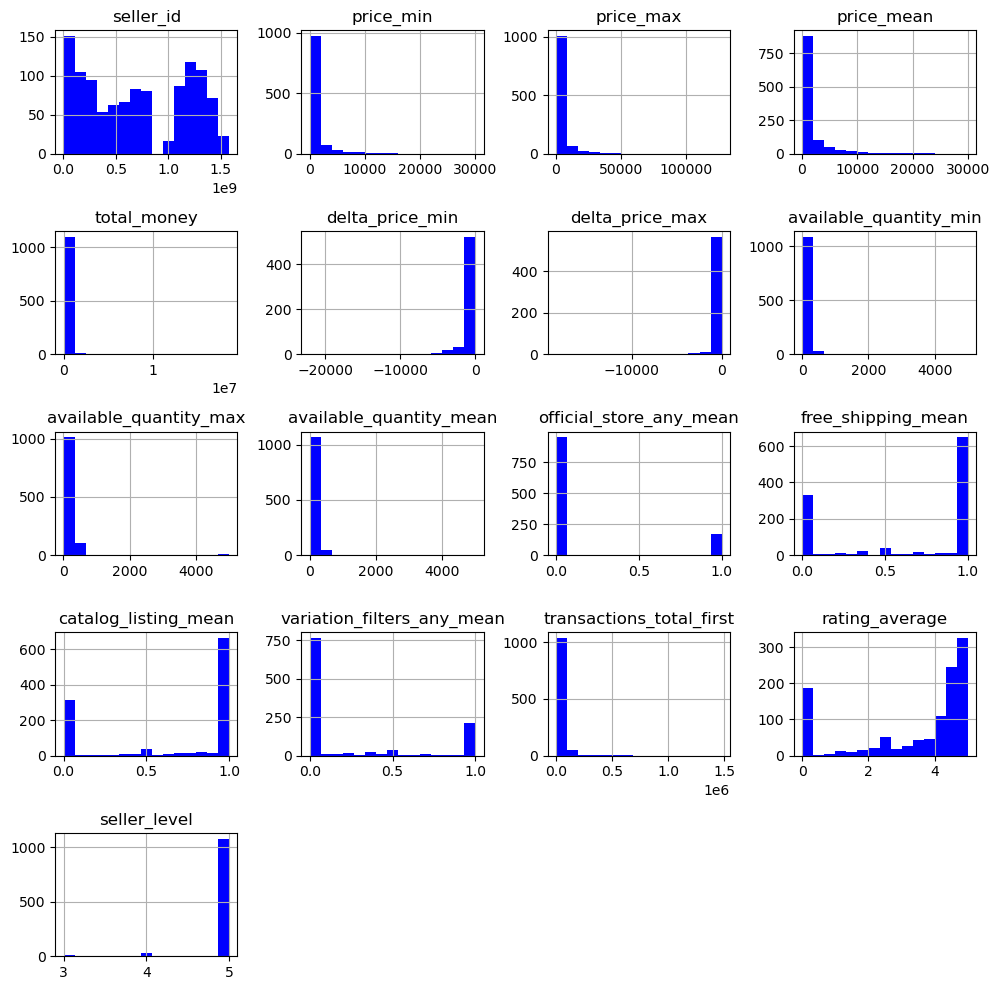

In [192]:
df_filtrado.hist(figsize=(10, 10),  bins=15, color='blue')
plt.tight_layout()
plt.show()

## Estandarizar variables numéricas

In [195]:
columns_clustering = [
    'listing_type_id_<lambda>','price_min', 'price_max', 'price_mean','total_money',
    'delta_price_min', 'delta_price_max',
    'available_quantity_min',
    'available_quantity_max', 'available_quantity_mean',
    'official_store_any_mean', 'free_shipping_mean', 'catalog_listing_mean',
    'variation_filters_any_mean', 'seller_level', 'seller_status',
    'transactions_total_first', 'differential_pricing', 'rating_average'
]

In [197]:
categorical_columns = [
    'listing_type_id_<lambda>','differential_pricing',
    'seller_status'
]

In [199]:
df_clustering = df[columns_clustering]

In [201]:
numeric_columns = [col for col in columns_clustering if col not in categorical_columns]

In [203]:
numeric_transformer = StandardScaler()
df_numeric_scaled = numeric_transformer.fit_transform(df_clustering[numeric_columns])

In [205]:
categorical_transformer = OneHotEncoder(drop='first', sparse=False) 
df_categorical_encoded = categorical_transformer.fit_transform(df_clustering[categorical_columns])

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [236]:
df_scaled = pd.DataFrame(
    data=np.concatenate([df_numeric_scaled, df_categorical_encoded], axis=1),
    columns=numeric_columns + list(categorical_transformer.get_feature_names_out(categorical_columns))
)

## Cluster usando k-means

In [239]:
df_scaled.head()

,price_min,price_max,price_mean,total_money,delta_price_min,delta_price_max,available_quantity_min,available_quantity_max,available_quantity_mean,official_store_any_mean,free_shipping_mean,catalog_listing_mean,variation_filters_any_mean,seller_level,transactions_total_first,rating_average,listing_type_id_<lambda>_gold_special,differential_pricing_{'id': 35713375},differential_pricing_{'id': 35713376},differential_pricing_{'id': 35713377},seller_status_platinum,seller_status_silver,seller_status_None
0,-0.443830,-0.244208,-0.376774,-0.087251,NaN,NaN,-0.272792,-0.334292,-0.337497,-0.424618,-0.096452,0.751949,-0.61646,0.185639,-0.162731,0.259309,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.661007,0.266008,1.024506,-0.137618,NaN,NaN,-0.272792,-0.334292,-0.337497,-0.424618,0.790960,0.751949,-0.61646,0.185639,-0.265699,0.773494,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.966038,0.363561,1.248515,-0.136918,NaN,NaN,-0.272792,-0.334292,-0.337497,-0.424618,0.790960,0.751949,-0.61646,0.185639,-0.065993,0.886502,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.250055,9.515812,4.512891,1.772339,NaN,NaN,-0.272792,-0.334292,-0.337497,-0.424618,0.790960,0.751949,-0.61646,0.185639,-0.345288,-0.916484,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.326005,2.029051,0.558344,0.861364,NaN,NaN,-0.272792,-0.334292,-0.337497,2.359169,0.790960,0.751949,-0.61646,0.185639,-0.033342,-0.675663,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [241]:
missing_values = df_scaled.isnull().sum()
print(missing_values)

price_min                                  0
price_max                                  0
price_mean                                 0
total_money                                0
delta_price_min                          536
delta_price_max                          536
available_quantity_min                     0
available_quantity_max                     0
available_quantity_mean                    0
official_store_any_mean                    0
free_shipping_mean                         0
catalog_listing_mean                       0
variation_filters_any_mean                 0
seller_level                               0
transactions_total_first                   0
rating_average                             1
listing_type_id_<lambda>_gold_special      0
differential_pricing_{'id': 35713375}      0
differential_pricing_{'id': 35713376}      0
differential_pricing_{'id': 35713377}      0
seller_status_platinum                     0
seller_status_silver                       0
seller_sta

In [243]:
df_scaled['delta_price_min']= df_scaled['delta_price_min'].fillna(0)
df_scaled['delta_price_max']= df_scaled['delta_price_max'].fillna(0)

In [245]:
df_scaled['rating_average']= df_scaled['rating_average'].fillna(0)

In [414]:
%%time
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
df_filtrado['cluster'] = kmeans.fit_predict(df_scaled)
df_scaled_cluster=df_scaled
df_scaled_cluster['cluster']=kmeans.fit_predict(df_scaled)

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<timed exec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



CPU times: user 6.29 s, sys: 2.06 s, total: 8.35 s
Wall time: 2.23 s


In [415]:
df_filtrado.cluster.value_counts()

cluster
0    672
1    357
2     87
3      5
Name: count, dtype: int64

## Analizar resultados

/tmp/ipykernel_780/3459535850.py:21: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



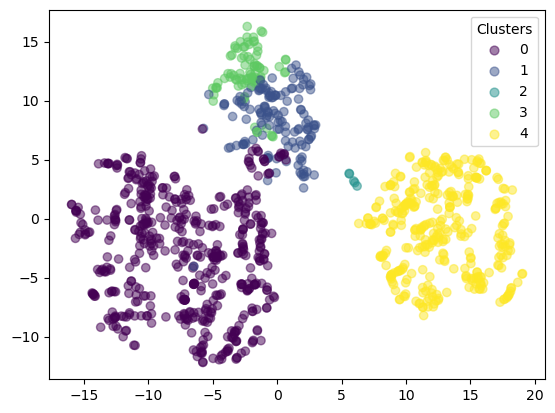

In [398]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=2024)
df_tsne = tsne.fit_transform(df_scaled)

scatter = plt.scatter(df_tsne[:, 0], 
                      df_tsne[:, 1], 
                      c=df_scaled_cluster['cluster'], 
                      cmap='viridis', 
                      alpha=0.5)

cluster_counts = df_scaled_cluster['cluster'].value_counts()

legend_labels = sorted(cluster_counts.index)

handles = []
for label in legend_labels:
   
    subset = df_scaled_cluster[df_scaled_cluster['cluster'] == label]
    
    handle = plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label=label, alpha=0.5)
    handles.append(handle)

legend = plt.legend(title='Clusters', loc='upper right', handles=handles)

for handle in legend.legend_handles:
    handle.set_sizes([40])

plt.show()


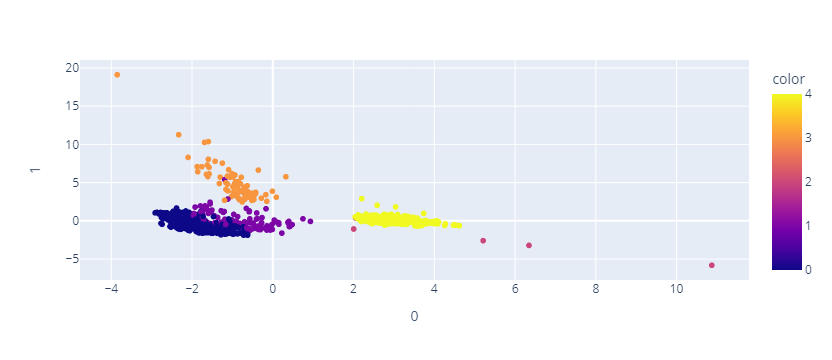

In [399]:
import plotly.express as px

from sklearn.decomposition import PCA

X = df_scaled_cluster

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=df_scaled_cluster['cluster'])
fig.show()

In [402]:
df_filtrado.columns

Index(['seller_id', 'listing_type_id_<lambda>', 'price_min', 'price_max',
       'price_mean', 'total_money', 'delta_price_min', 'delta_price_max',
       'available_quantity_min', 'available_quantity_max',
       'available_quantity_mean', 'official_store_any_mean',
       'free_shipping_mean', 'catalog_listing_mean',
       'variation_filters_any_mean', 'seller_status',
       'transactions_total_first', 'rating_average', 'differential_pricing',
       'transactions_general', 'seller_level', 'cluster'],
      dtype='object')

In [403]:
df_filtrado.seller_status.value_counts(dropna=False)

seller_status
platinum    650
gold        187
None        158
silver      126
Name: count, dtype: int64

In [404]:
#df_plot=df_filtrado[df_filtrado['cluster']!=3]
df_plot=df_filtrado.drop(['transactions_general'], axis='columns')

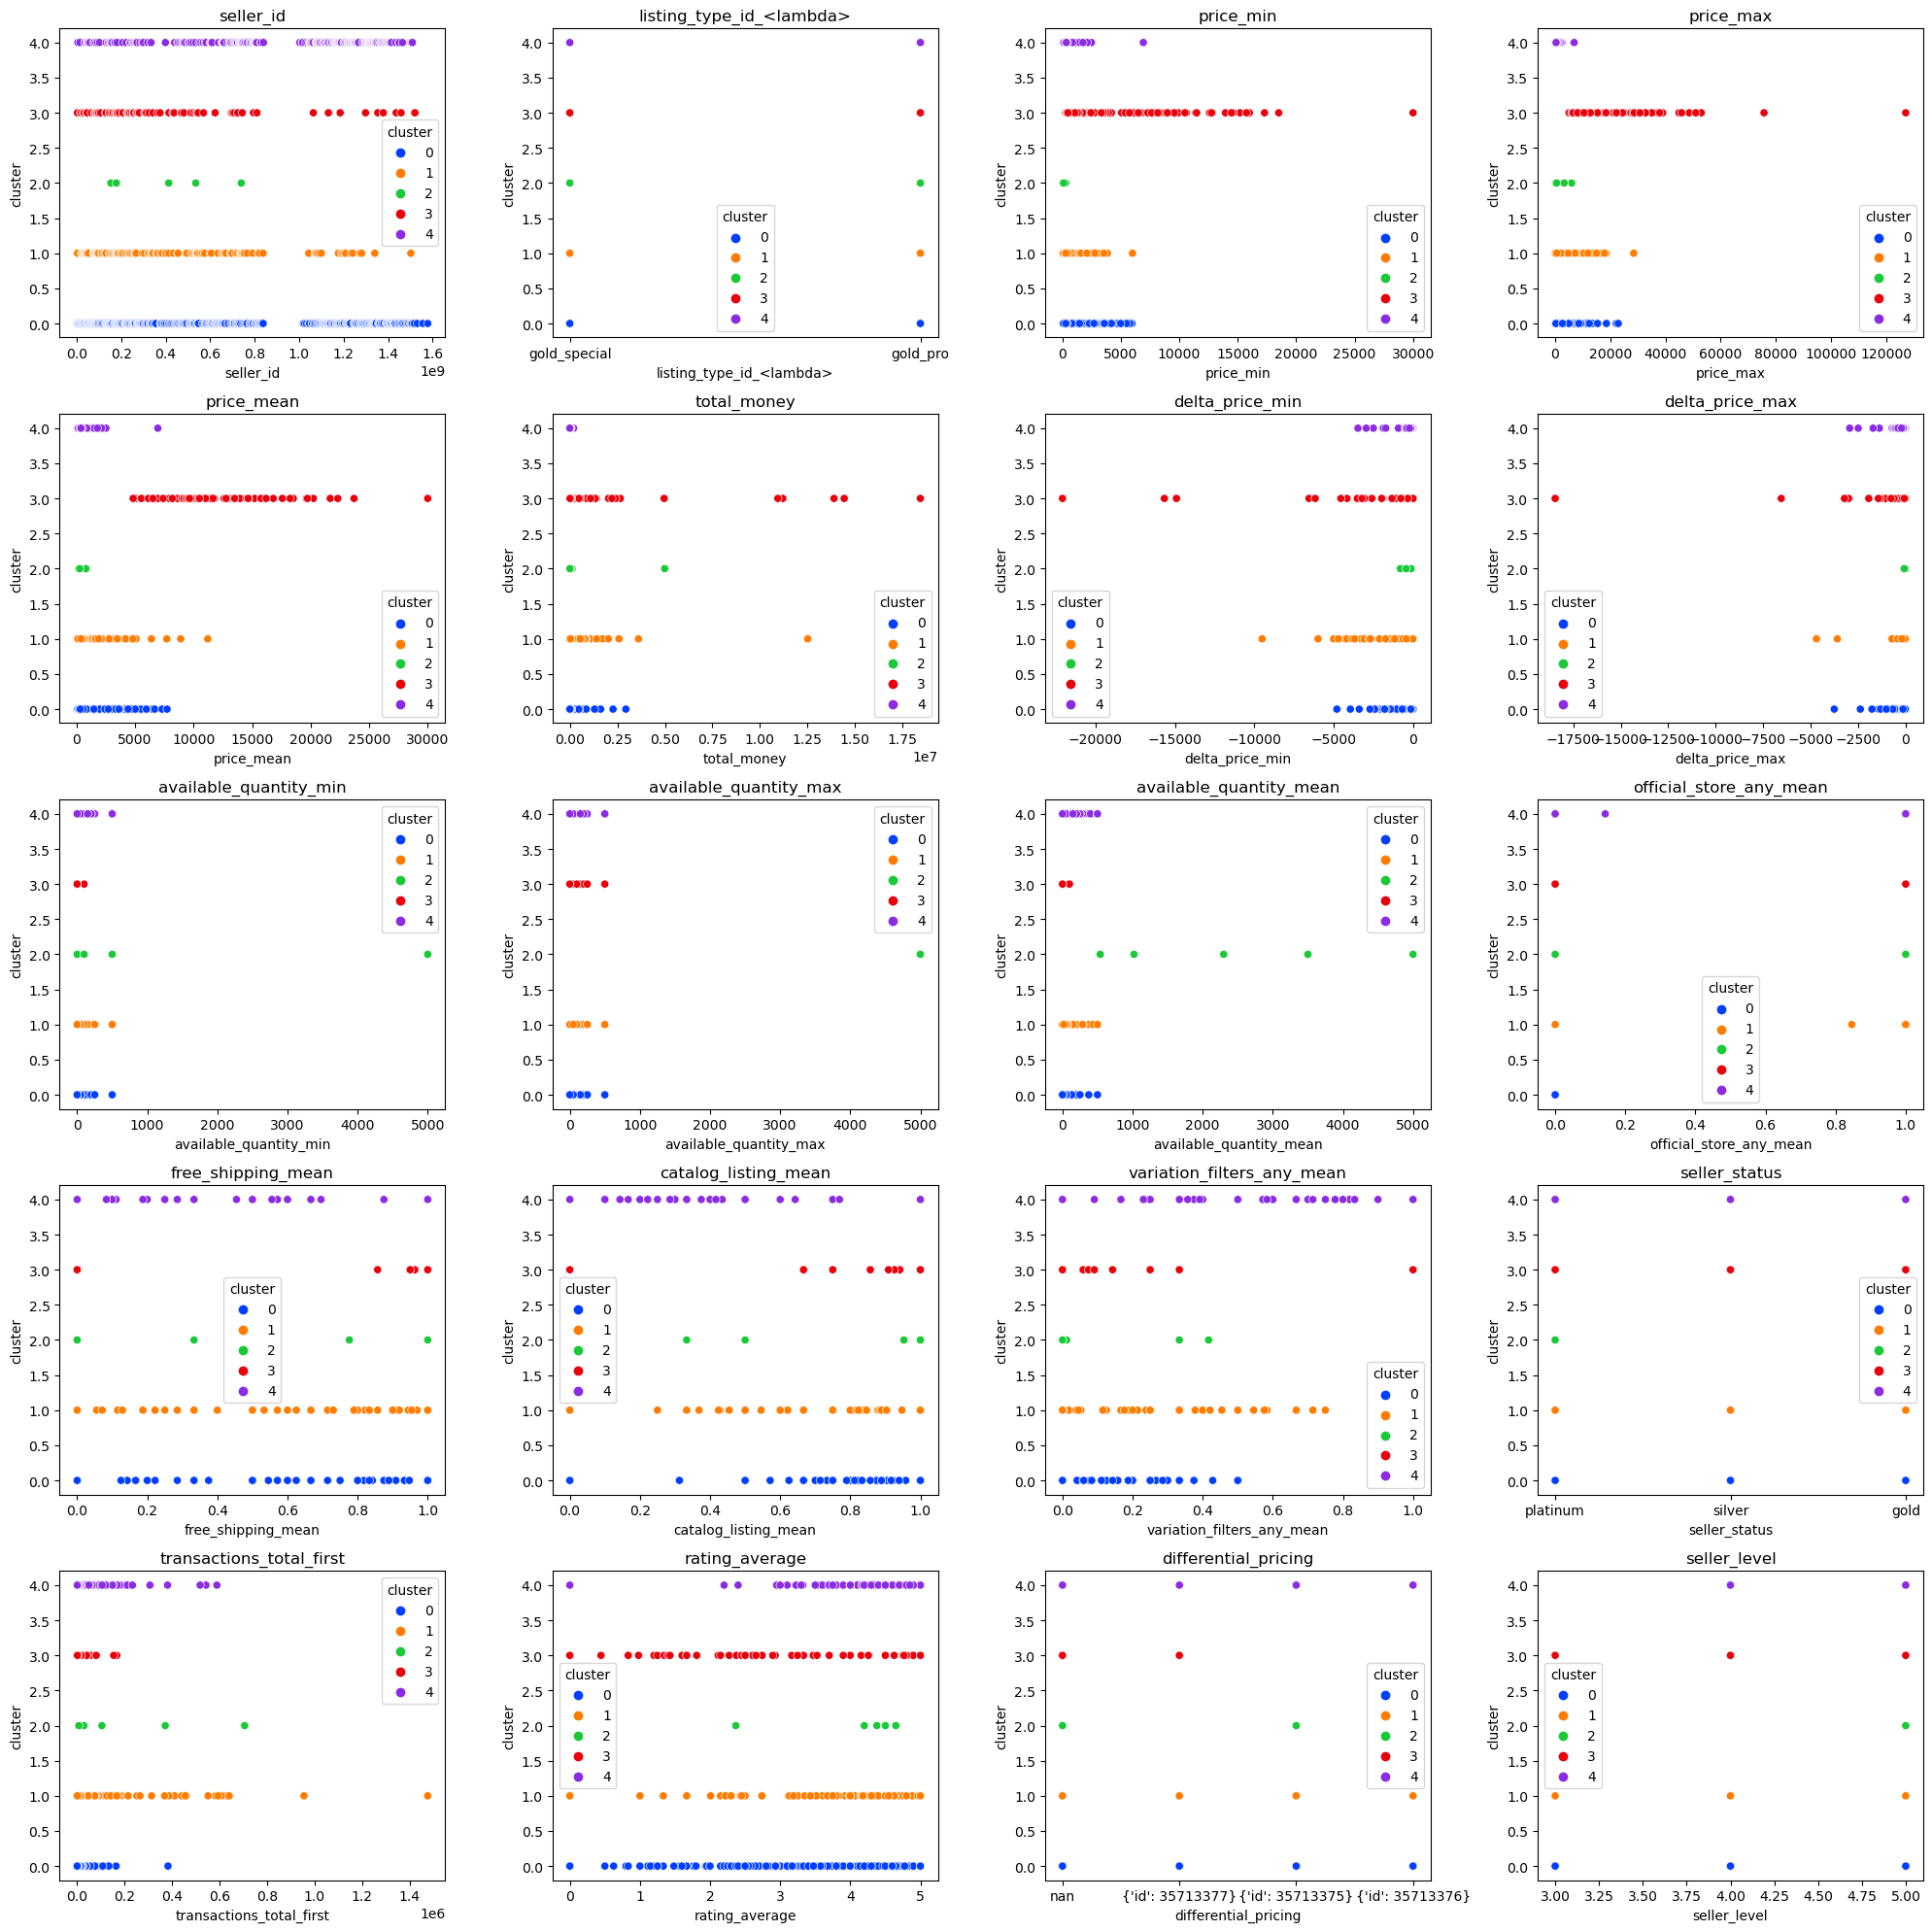

In [405]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), dpi=100)
axes = axes.flatten()

for i, feature in enumerate(df_filtrado.drop(['cluster', 'transactions_general'], axis='columns').columns):
    sns.scatterplot(data=df_plot,x=feature,y='cluster', ax=axes[i], hue='cluster', palette='bright')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

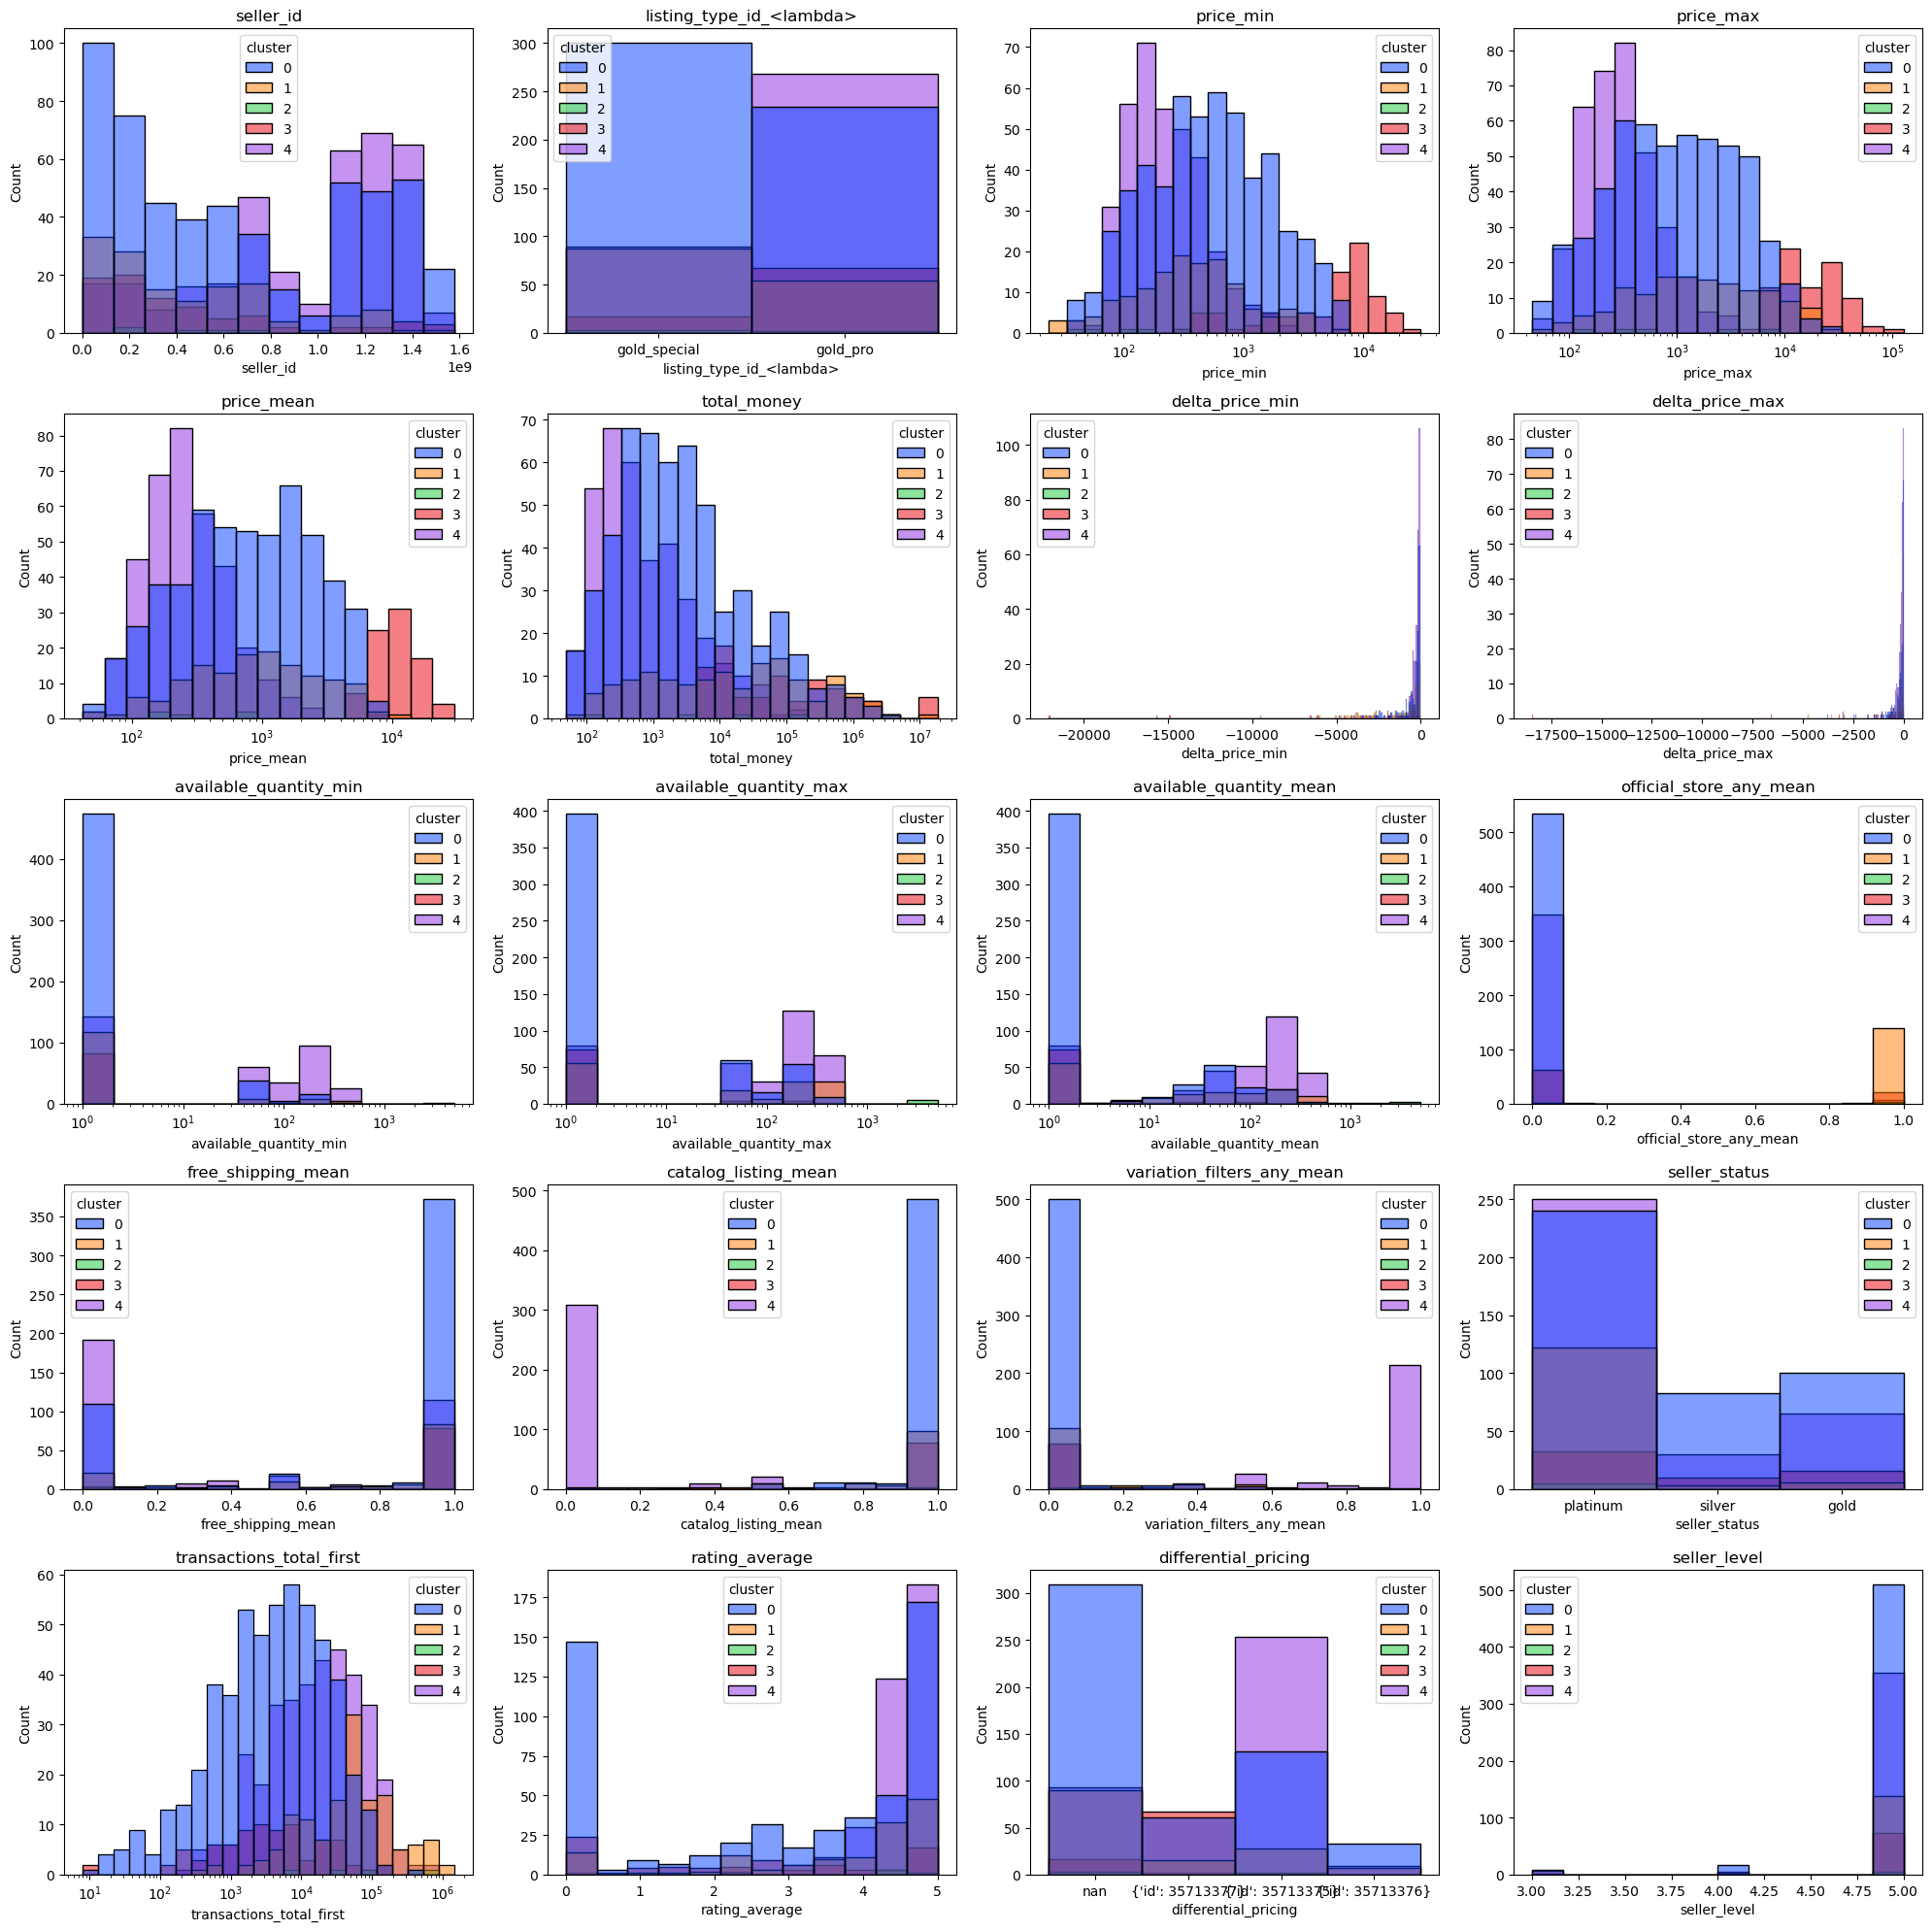

In [406]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20), dpi=100)
axes = axes.flatten()

for i, feature in enumerate(df_filtrado.drop(['cluster', 'transactions_general'], axis='columns').columns):
    logscale=False
    if feature in ['price_min','price_max','price_mean','total_money', 
                   'available_quantity_min',
                  'available_quantity_max', 'available_quantity_mean', 
                   'transactions_total_first']: logscale=True
    sns.histplot(data=df_plot, x=feature, hue='cluster', palette='bright', ax=axes[i], log_scale=logscale)
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()
